In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pickle
import os
from sklearn.decomposition import NMF, PCA
from sklearn.cluster import KMeans
from importlib import reload

import sys
sys.path.insert(1, '/Users/madisonthantu/Desktop/DREAM/t-recs')
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement
from trecs.components import Users
import trecs.matrix_ops as mo
import src.globals as globals
import seaborn as sns

from wrapper.models.bubble import BubbleBurster
from src.utils import *
from src.plotting import plot_measurements 
from src.scoring_functions import cosine_sim, entropy, content_fairness, cosine_sim2
from wrapper.metrics.evaluation_metrics import *

random_state = np.random.seed(42)
plt.style.use("seaborn")

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

globals.initialize()

/var/folders/sm/hcy50x855gvf2b1qwkjstnvh0000gn/T/ipykernel_75897/2028533230.py:26: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


# RecommenderSystem on MovieLens 

In [2]:
n_attrs=20
max_iter=1000
n_clusters=10

In [3]:
score_fn = None #'entropy' # 'cosine_sim2'
probabilistic = False
globals.ALPHA = 0.1
alpha = globals.ALPHA

# User parameters
drift = 0.2 #0.1, 0.2, 0.5
attention_exp=-0.8

retrain = False

## Embeddings

In [4]:
binary_ratings_matrix = load_and_process_movielens(file_path='/Users/madisonthantu/Desktop/DREAM/data/ml-100k/u.data')

In [5]:
# Get user and item representations using NMF
user_representation, item_representation = create_embeddings(binary_ratings_matrix, n_attrs=n_attrs, max_iter=max_iter)

Loaded embeddings.


In [6]:
# Define topic clusters using NMF
item_cluster_ids, item_cluster_centers = get_clusters(item_representation.T, name='item', n_clusters=n_clusters, n_attrs=n_attrs, max_iter=max_iter)
user_cluster_ids, user_cluster_centers = get_clusters(user_representation, name='user', n_clusters=n_clusters, n_attrs=n_attrs, max_iter=max_iter)

Loaded clusters.
Loaded clusters.


### Model

In [7]:
num_users = len(user_representation)
num_items = len(item_representation)
print(f'Number of items: {num_items}')
print(f'Number of users: {num_users}')

users = Users(actual_user_profiles=user_representation, 
              repeat_interactions=False, 
              drift=drift,
              attention_exp=attention_exp)

Number of items: 20
Number of users: 943


In [8]:
# Create user_pairs by pairing users only with others that are not in the same cluster
user_item_cluster_mapping = user_topic_mapping(user_representation, item_cluster_centers) # TODO: Remove?
# Create user_pairs by pairing users only with others that are not in the same cluster
inter_cluster_user_pairs, intra_cluster_user_pairs = create_cluster_user_pairs(user_item_cluster_mapping)

In [9]:
mse = MSEMeasurement()
measurements = [
    InteractionMeasurement(),
    MSEMeasurement(),  
    InteractionSpread(),                
    InteractionSimilarity(pairs=inter_cluster_user_pairs, name='inter_cluster_interaction_similarity'), 
    InteractionSimilarity(pairs=intra_cluster_user_pairs, name='intra_cluster_interaction_similarity'), 
    RecSimilarity(pairs=inter_cluster_user_pairs, name='inter_cluster_rec_similarity'), 
    RecSimilarity(pairs=intra_cluster_user_pairs, name='intra_cluster_rec_similarity'), 
    UserMSEMeasurement(),
    # SerendipityMetric(), 
    DiversityMetric(), 
    # NoveltyMetric(),
    RecallMeasurement(),
    MeanNumberOfTopics(),
    IntraClusterCosineSim(mapping=user_item_cluster_mapping, n_clusters=n_clusters, name='intra_user_to_topic_cluster_cos_sim'),
    IntraClusterCosineSim(mapping=user_cluster_ids, n_clusters=n_clusters, name='intra_user_cluster_cos_sim'),
    MeanDistanceFromCentroid(user_cluster_ids, user_cluster_centers, name='user_cluster_avg_distance_from_centroid'),
]

In [10]:
# Model
config = {
    'actual_user_representation': users,
    'actual_item_representation': item_representation,
    'item_topics': item_cluster_ids,
    'num_attributes': n_attrs,
    'num_items_per_iter': 10,
    'seed': 42,
    'record_base_state': True,
}

model_name='myopic'
requires_alpha = False

if score_fn:
    if score_fn == 'cosine_sim2':
        config['score_fn'] = cosine_sim2
    elif score_fn == 'cosine_sim':
        config['score_fn'] = cosine_sim
        requires_alpha = True
    elif score_fn == 'entropy':
        config['score_fn'] = entropy
        requires_alpha = True
    elif score_fn == 'content_fairness':
        config['score_fn'] = content_fairness        
    else:
        raise Exception('Given score function does not exist.')
    # assert(config['score_fn'] == cosine_sim2)
    model_name = score_fn

if probabilistic:
    config['probabilistic_recommendations'] = True
    model_name += '_prob'

In [11]:
model = BubbleBurster(**config)

model.add_metrics(*measurements)

## Simulation

In [12]:
# Fair Model
train_timesteps=10
model.startup_and_train(timesteps=train_timesteps)

100%|██████████| 10/10 [00:21<00:00,  2.18s/it]


In [13]:
run_timesteps=100
model.run(timesteps=run_timesteps, train_between_steps=retrain)

 89%|████████▉ | 89/100 [08:22<01:22,  7.48s/it]/Users/madisonthantu/Desktop/DREAM/t-recs/trecs/matrix_ops.py:573: RuntimeWarning: invalid value encountered in divide
  np.sin((1.0 - perc) * omega) / sin_o * mat1_norm.T
/Users/madisonthantu/Desktop/DREAM/t-recs/trecs/matrix_ops.py:574: RuntimeWarning: invalid value encountered in divide
  + np.sin(perc * omega) / sin_o * mat2_norm.T
100%|██████████| 100/100 [09:48<00:00,  5.88s/it]


In [18]:
import src
reload(src.utils)
from src.utils import *
    
# Determine file name based on parameter values
parameters = f'_{train_timesteps}trainTimesteps_{run_timesteps}runTimesteps_{n_attrs}nAttrs_{n_clusters}nClusters_{drift}Drift_{attention_exp}AttentionExp'
if requires_alpha:
    parameters += f'_{alpha}Lambda'

# Save actual user preferences
final_preferences_dir = 'artefacts/final_preferences/'
file_prefix = f'{model_name}_final_preferences'
final_preferences_path = final_preferences_dir + file_prefix + parameters + '.npy'
np.save(final_preferences_path, model.users.actual_user_profiles.value, allow_pickle=True)

# Save measurements
measurements_dir = f'artefacts/measurements/'
file_prefix = f'{model_name}_measurements'

measurements_path = measurements_dir + file_prefix + parameters + '.csv'
measurements_df = load_or_create_measurements_df(model, model_name, train_timesteps, measurements_path)
measurements_df.to_csv(measurements_path)
print('Measurements saved.')

Measurements saved.


In [25]:
def create_measurements_df(model, model_name, train_timesteps, file_path):
    measurements = model.get_measurements()
    df = pd.DataFrame(measurements)
    df['state'] = 'train' # makes it easier to later understand which part was training
    df.loc[df['timesteps'] > train_timesteps, 'state'] = 'run'
    df['model'] = model_name
    
    return df

,interaction_histogram,mse,interaction_spread,timesteps,state,model
0,NaN,0.090065,NaN,0,train,myopic
1,[6. 0. 1. ... 0. 0. 0.],0.107565,-939.0,1,train,myopic
2,[1. 2. 1. ... 0. 0. 0.],0.122300,-0.5,2,train,myopic
3,[2. 0. 2. ... 0. 0. 0.],0.135919,0.0,3,train,myopic
4,[2. 1. 3. ... 0. 0. 0.],0.148202,-0.5,4,train,myopic
...,...,...,...,...,...,...
106,[0. 0. 2. ... 2. 1. 2.],NaN,-3.0,106,run,myopic
107,[2. 0. 0. ... 2. 0. 6.],NaN,3.5,107,run,myopic
108,[0. 0. 1. ... 1. 1. 3.],NaN,-0.5,108,run,myopic
109,[0. 0. 1. ... 1. 0. 2.],NaN,2.5,109,run,myopic


In [24]:
print(measurements_path)
measurements = model.get_measurements()
for k in measurements:
    print(k)

artefacts/measurements/myopic_measurements_10trainTimesteps_100runTimesteps_20nAttrs_10nClusters_0.2Drift_-0.8AttentionExp.csv
interaction_histogram
mse
interaction_spread
inter_cluster_interaction_similarity
intra_cluster_interaction_similarity
inter_cluster_rec_similarity
intra_cluster_rec_similarity
user_mse
serendipity_metric
diversity_metric
novelty_metric
recall_at_k
mean_num_topics
intra_user_to_topic_cluster_cos_sim
intra_user_cluster_cos_sim
user_cluster_avg_distance_from_centroid
timesteps


## Analysis

In [20]:
# Create df for parameters
numeric_cols = ['trainTimesteps', 'runTimesteps', 'nAttrs', 'nClusters', 'Lambda']
columns = ['model_name'] + numeric_cols

data = [[model_name, train_timesteps, run_timesteps, n_attrs, n_clusters, None]]
if requires_alpha:
    data = [[model_name, train_timesteps, run_timesteps, n_attrs, n_clusters, alpha]]

parameters_df = pd.DataFrame(data,
                             columns = columns)
for col in numeric_cols:
    parameters_df[col] = pd.to_numeric(parameters_df[col])

In [21]:
print(measurements_df.isna())
# print(measurements_df.isna().sum().sum())
measurements_df[:]

     interaction_histogram    mse  interaction_spread  timesteps  state  model
0                     True  False                True      False  False  False
1                    False  False               False      False  False  False
2                    False  False               False      False  False  False
3                    False  False               False      False  False  False
4                    False  False               False      False  False  False
..                     ...    ...                 ...        ...    ...    ...
106                  False   True               False      False  False  False
107                  False   True               False      False  False  False
108                  False   True               False      False  False  False
109                  False   True               False      False  False  False
110                  False   True               False      False  False  False

[111 rows x 6 columns]


,interaction_histogram,mse,interaction_spread,timesteps,state,model
0,NaN,0.090065,NaN,0,train,myopic
1,[6. 0. 1. ... 0. 0. 0.],0.107565,-939.0,1,train,myopic
2,[1. 2. 1. ... 0. 0. 0.],0.122300,-0.5,2,train,myopic
3,[2. 0. 2. ... 0. 0. 0.],0.135919,0.0,3,train,myopic
4,[2. 1. 3. ... 0. 0. 0.],0.148202,-0.5,4,train,myopic
...,...,...,...,...,...,...
106,[0. 0. 2. ... 2. 1. 2.],NaN,-3.0,106,run,myopic
107,[2. 0. 0. ... 2. 0. 6.],NaN,3.5,107,run,myopic
108,[0. 0. 1. ... 1. 1. 3.],NaN,-0.5,108,run,myopic
109,[0. 0. 1. ... 1. 0. 2.],NaN,2.5,109,run,myopic


In [ ]:
def plot_measurements(dfs, parameters_df, ignored_train_ts=0):
    fig, ax = plt.subplots(4, 3, figsize=(15, 15))
    fig.tight_layout(pad=5.0)
    colors = plt.get_cmap('tab10')

    # plot rec_similarity with timesteps on x axis
    legend_lines, legend_names = [], []
    for i, df in enumerate(dfs):
        ts = df['timesteps'][ignored_train_ts:]
        name = parameters_df.loc[i, 'model_name']
        if not np.isnan(parameters_df.loc[i, 'Lambda']):
            name += f" (Lambda: {parameters_df.loc[i, 'Lambda']})"
        legend_names.append(name)
        
        line, = ax[0,0].plot(ts, df['mse'][ignored_train_ts:], label=name, alpha=0.5, color=colors(i))
        # ax[0,1].plot(ts, df['user_mse'], label=name)
        if 'recall_at_k' in df.columns:
            ax[0,1].plot(ts, df['recall_at_k'][ignored_train_ts:], label=name, alpha=0.5, color=colors(i))
    
        if 'interaction_spread' in df.columns:
            ax[1,0].plot(ts, df['interaction_spread'][ignored_train_ts:], label=name, alpha=0.5, color=colors(i))
        if 'inter_cluster_interaction_similarity' in df.columns:
            ax[1,1].plot(ts, df['inter_cluster_interaction_similarity'][ignored_train_ts:], label=name, alpha=0.5, color=colors(i))
        if 'intra_cluster_interaction_similarity' in df.columns:
            ax[1,2].plot(ts, df['intra_cluster_interaction_similarity'][ignored_train_ts:], label=name, alpha=0.5, color=colors(i))

        if 'diversity_metric' in df.columns:
            ax[2,0].plot(ts, df['diversity_metric'][ignored_train_ts:], label=name, alpha=0.5, color=colors(i))
        if 'inter_cluster_rec_similarity' in df.columns:
            ax[2,1].plot(ts, df['inter_cluster_rec_similarity'][ignored_train_ts:], label=name, alpha=0.5, color=colors(i))
        if 'intra_cluster_rec_similarity' in df.columns:
            ax[2,2].plot(ts, df['intra_cluster_rec_similarity'][ignored_train_ts:], label=name, alpha=0.5, color=colors(i))

        if 'serendipity_metric' in df.columns:
            ax[3,0].plot(ts, df['serendipity_metric'][ignored_train_ts:], label=name, alpha=0.5, color=colors(i))
        if 'novelty_metric' in df.columns:
            ax[3,1].plot(ts, df['novelty_metric'][ignored_train_ts:], label=name, alpha=0.5, color=colors(i))
        if 'mean_num_topics' in df.columns:
            ax[3,2].plot(ts, df['mean_num_topics'][ignored_train_ts:], label=name, alpha=0.5, color=colors(i))
        
        legend_lines.append(line)

    for a in ax:
        for b in a:
            b.set_xlabel('Timestep')

    ax[0, 0].set_title('Mean Squared Error')
    ax[0, 0].set_ylabel('MSE')

    ax[0, 1].set_title('Top-5 Recall')
    ax[0, 1].set_ylabel('Recall')
    ax[0, 1].set_xlabel('Timesteps')

    ax[0, 2].set_title('')
    ax[0, 2].set_ylabel('')

    ax[1, 0].set_title('Interaction Spread')
    ax[1, 0].set_ylabel('Jaccard Similarity')

    ax[1, 1].set_title('Inter Cluster Interaction Similarity')
    ax[1, 1].set_ylabel('Jaccard Similarity')

    ax[1, 2].set_title('Intra Cluster Interaction Similarity')
    ax[1, 2].set_ylabel('Jaccard Similarity')

    ax[2, 0].set_title('Diversity')
    ax[2, 0].set_ylabel('Diversity')

    ax[2, 1].set_title('Inter Cluster Recommendation similarity')
    ax[2, 1].set_ylabel('Jaccard Similarity')

    ax[2, 2].set_title('Intra Cluster Recommendation similarity')
    ax[2, 2].set_ylabel('Jaccard Similarity')

    ax[3, 0].set_title('Serendipity')
    ax[3, 0].set_ylabel('Serendipity')

    ax[3, 1].set_title('Novelty')
    ax[3, 1].set_ylabel('Novelty')

    ax[3, 2].set_title('Mean Number of Topics Interacted per User')
    ax[3, 2].set_ylabel('Mean Number of Topics Interacted per User')

    fig.legend(legend_lines,
               legend_names,
               loc='upper center',
               fontsize=12,
               frameon=False,
               ncol=5,
               bbox_to_anchor=(.5, 1.02))


Model name = entropy
# clusters = 10
Drift = 0.2
train_between_steps = False


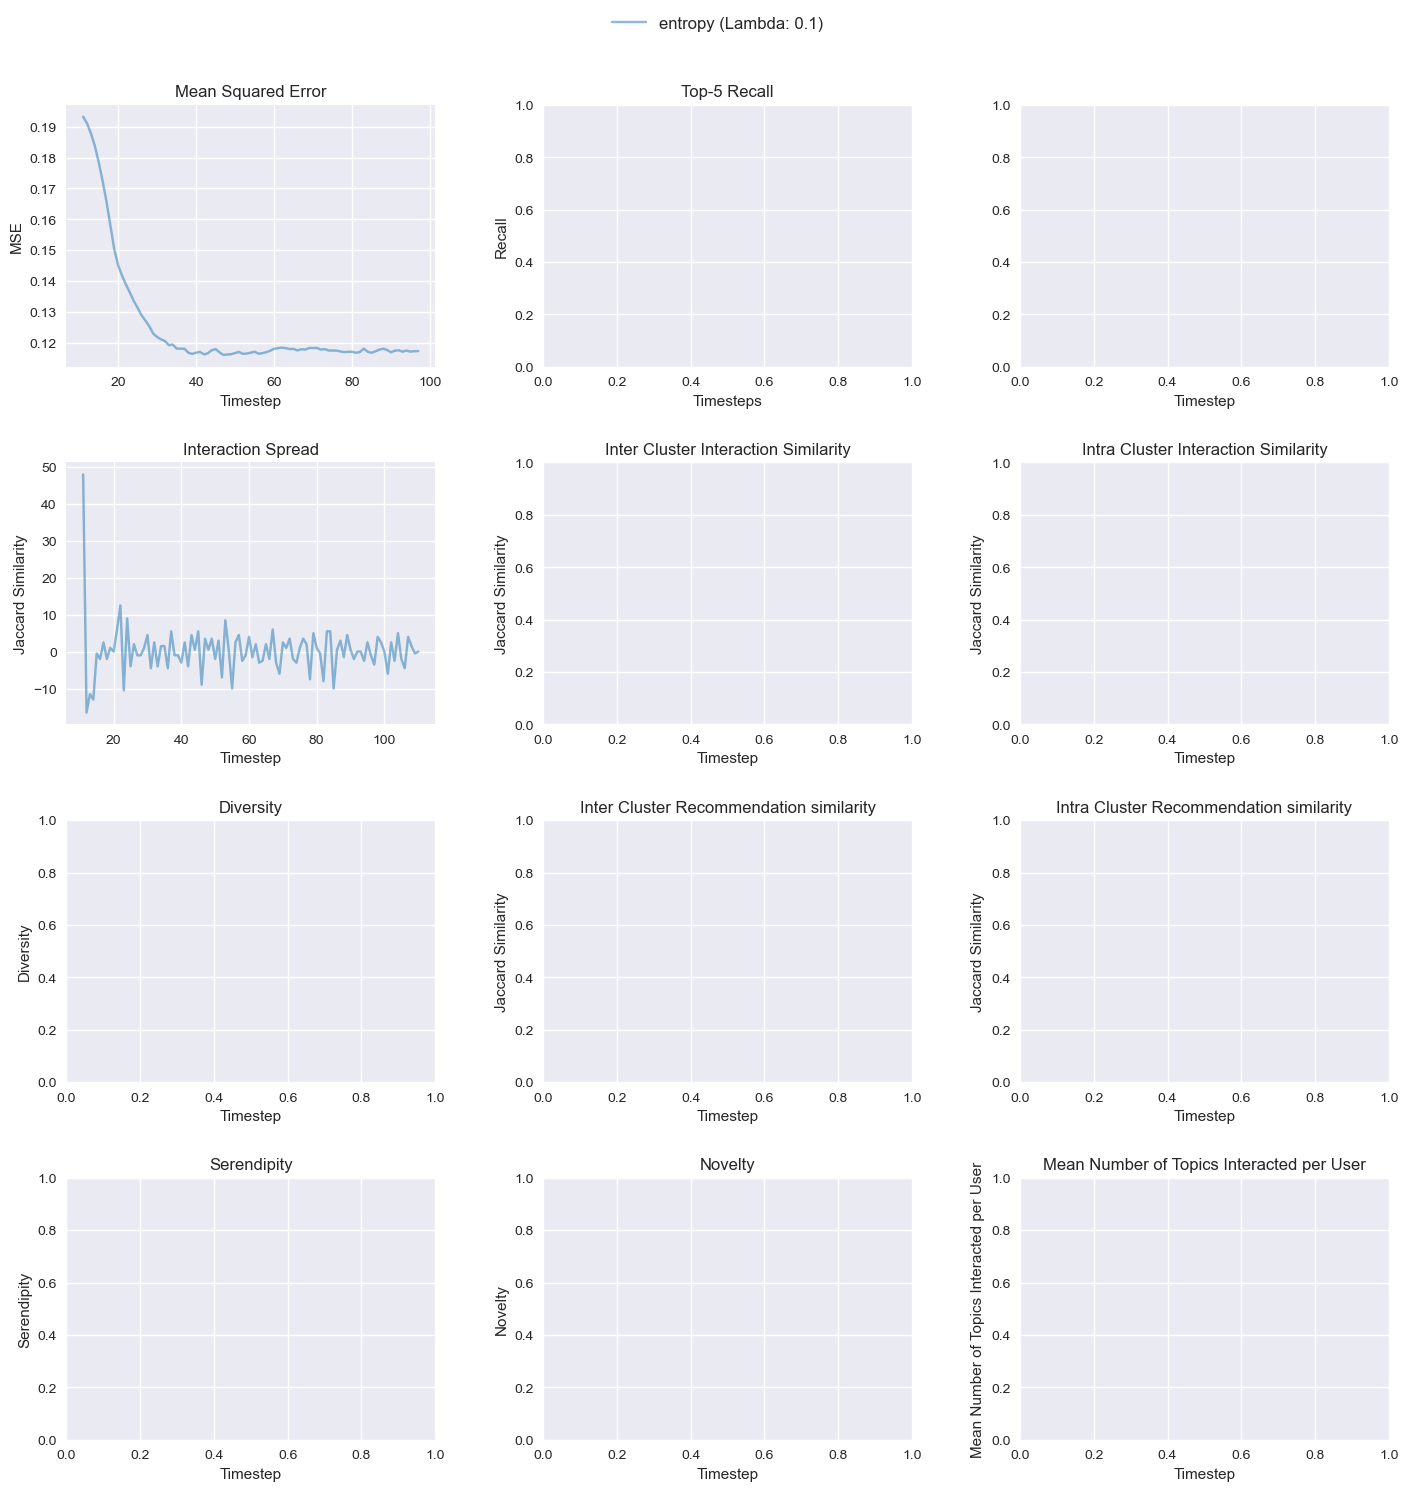

In [18]:
print("Model name =", model_name)
print("# clusters =", n_clusters)
print("Drift =", drift)
print("train_between_steps =", retrain)
plot_measurements([measurements_df[11:]], parameters_df)

In [19]:
sum(measurements_df['mse'] == previous_mse)

NameError: name 'previous_mse' is not defined

In [ ]:
previous_mse[:20]

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11    0.122604
12    0.125777
13    0.128440
14    0.130833
15    0.133147
16    0.135162
17    0.136649
18    0.137943
19    0.139141
Name: mse, dtype: float64

In [ ]:
measurements_df['mse']

0      0.090065
1      0.094148
2      0.097860
3      0.101707
4      0.105632
         ...   
106    0.120453
107    0.120296
108    0.120195
109    0.120185
110    0.120058
Name: mse, Length: 111, dtype: float64

In [ ]:
print("Model name =", model_name)
print("# clusters =", n_clusters)
print("Drift =", drift)
print("train_between_steps =", retrain)

previous_mse = measurements_df['mse']
previous_mse

Model name = cosine_sim2
# clusters = 10
Drift = 0.05
train_between_steps = False


0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
106    0.105888
107    0.105712
108    0.105582
109    0.105559
110    0.105420
Name: mse, Length: 111, dtype: float64

# Experiments

In [ ]:
# def plot_histograms(measurements_df):
#     # for every 10 timesteps plot line in different color
#     fig= plt.figure(figsize=(5, 5))
    
#     timesteps = len(measurements_df)
#     items = np.arange(len(measurements_df['interaction_histogram'][1]))
#     for i in range(10, timesteps+1, 10):
#         counts = measurements_df['interaction_histogram'][i]
#         plt.plot(items, sorted(counts), label=f't={i}')

#     plt.title('Interaction Histogram')
#     plt.xlabel('Items')
#     plt.ylabel('# Interactions')
#     plt.legend()
    
# plot_histograms(measurements_df)

In [ ]:
# recommender = model

In [ ]:
# # Novelty that is based on probability calculation from generate_recommendations 
# # (leave previously interacted items out)
# item_counts = recommender.item_count
# item_counts[item_counts == 0] = 1
# items_self_info = (-1) * np.log(item_counts)

# # turn scores in probability distribution over items to ensure that all independent of the ranking function, the metric yields comparable values
# scores = recommender.predicted_scores.value
# probabilities = scores / np.sum(scores, axis=1)[:, np.newaxis]

# item_indices = recommender.indices
# if not recommender.users.repeat_interactions:
#     # for each user, eliminate items that have been interacted with
#     item_indices = item_indices[np.where(item_indices >= 0)]
#     item_indices = item_indices.reshape((recommender.num_users, -1))

# s_filtered = mo.to_dense(recommender.predicted_scores.filter_by_index(item_indices))
# row = np.repeat(recommender.users.user_vector, item_indices.shape[1])
# row = row.reshape((recommender.num_users, -1))
# permutation = s_filtered.argsort()
# rec = item_indices[row, permutation]
# # the recommended items will not be exactly determined by
# # predicted score; instead, we will sample from the sorted list
# # such that higher-preference items get more probability mass
# num_items_unseen = rec.shape[1]  # number of items unseen per user
# probabilities = np.logspace(0.0, num_items_unseen / 10.0, num=num_items_unseen, base=2)
# probabilities = probabilities / probabilities.sum()

# # get utility of each item given a state of users
# item_states = np.mean(probabilities, axis=0)

# # calculate novelty per item by multiplying self information and utility value
# item_novelties = items_self_info * item_states
# # form sum over all possible items/actions
# item_novelty = np.sum(item_novelties)

# item_novelty